# Ex07 - Propriedades da DFT

## Resolução Parte 1

In [402]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from numpy.fft import *
import sys,os
from scipy import signal
from PIL import Image

In [403]:
def pconv(f,h):
    import numpy as np

    h_ind=np.nonzero(h)
    f_ind=np.nonzero(f)
    if len(h_ind[0])>len(f_ind[0]):
        h,    f    = f,    h
        h_ind,f_ind= f_ind,h_ind

    gs = np.maximum(np.array(f.shape),np.array(h.shape))
    if (f.dtype == 'complex') or (h.dtype == 'complex'):
        g = np.zeros(gs,dtype='complex')
    else:
        g = np.zeros(gs)

    f1 = g.copy()
    f1[f_ind]=f[f_ind]      

    if f.ndim == 1:
        (W,) = gs
        col = np.arange(W)
        for cc in h_ind[0]:
            g[:] += f1[(col-cc)%W] * h[cc]

    elif f.ndim == 2:
        H,W = gs
        row,col = np.indices(gs)
        for rr,cc in np.transpose(h_ind):
            g[:] += f1[(row-rr)%H, (col-cc)%W] * h[rr,cc]

    else:
        Z,H,W = gs
        d,row,col = np.indices(gs)
        for dd,rr,cc in np.transpose(h_ind):
            g[:] += f1[(d-dd)%Z, (row-rr)%H, (col-cc)%W] * h[dd,rr,cc]
    return g

def ptrans2d(f,t):
    rr,cc = t
    H,W = f.shape
    
    r = rr%H
    c = cc%W
        
    g = np.empty_like(f)
    
    g[:r,:c] = f[H-r:H,W-c:W]
    g[:r,c:] = f[H-r:H,0:W-c]
    g[r:,:c] = f[0:H-r,W-c:W]
    g[r:,c:] = f[0:H-r,0:W-c]

    return g

def myfft2(figure):
    h,w = figure.shape
    F = np.fft.fft2(figure)
    Ff = np.log(ptrans2d(F, (h//2, w//2))+1)
    return Ff

def view_fft2(figure):
    h,w = figure.shape
    Ff = np.log(ptrans2d(F, (h//2, w//2))+1)
    return np.abs(Ff)

def normalize(f, range=[0,255]):

    f = np.asarray(f)
    range = np.asarray(range)
    if f.dtype.char in ['D', 'F']:
        raise Exception('error: cannot normalize complex data')
    faux = np.ravel(f).astype(float)
    minimum = faux.min()
    maximum = faux.max()
    lower = range[0]
    upper = range[1]
    if upper == lower:
        g = np.ones(f.shape) * maximum
    if minimum == maximum:
        g = np.ones(f.shape) * (upper + lower) / 2.
    else:
        g = (faux-minimum)*(upper-lower) / (maximum-minimum) + lower
    g = g.reshape(f.shape)

    if f.dtype == np.uint8:
        if upper > 255: 
            raise Exception('normalize: warning, upper valuer larger than 255. Cannot fit in uint8 image')
    if lower == 0 and upper == 255:
        g = g.astype(np.uint8)
    else:
        g = g.astype(f.dtype) # set data type of result the same as the input image
    return g

def circle(s, r, c): #s: dimensões fora da imagem, r: raio, c: centro da imagem
    rows, cols = s[0], s[1]
    rr0,  cc0  = c[0], c[1]
    rr, cc = np.meshgrid(range(rows), range(cols), indexing='ij')
    g = (rr - rr0)**2 + (cc - cc0)**2 <= r**2
    return g

In [404]:
x = np.zeros((5,5))
x[1:3:2, 1:3:2] = 1
print 'x: \n', x

k = np.ones((3,3))
print 'k: \n', k , '\n'

y = signal.convolve2d(x, k, mode='same')
print 'Convolução utilizando a função scipy: \n', y, '\n'

z = pconv(x, k)
print 'Convolução periódica utilizando a função pconv: \n', z

x: 
[[ 0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
k: 
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]] 

Convolução utilizando a função scipy: 
[[ 1.  1.  1.  0.  0.]
 [ 1.  1.  1.  0.  0.]
 [ 1.  1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]] 

Convolução periódica utilizando a função pconv: 
[[ 0.  0.  0.  0.  0.]
 [ 0.  1.  1.  1.  0.]
 [ 0.  1.  1.  1.  0.]
 [ 0.  1.  1.  1.  0.]
 [ 0.  0.  0.  0.  0.]]


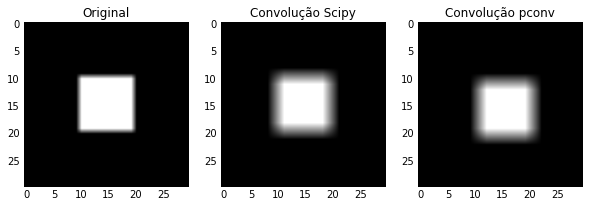

In [405]:
g = np.zeros((30, 30))
g[10:20:, 10:20:]= 255

j = signal.convolve2d(g, k, mode='same')

i = pconv(g, k)

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(g, cmap='gray')
ax[1].imshow(j, cmap='gray')
ax[2].imshow(i, cmap='gray')

ax[0].set_title('Original')
ax[1].set_title(u'Convolução Scipy')
ax[2].set_title(u'Convolução pconv')
plt.show()

Utilizando a convolução periódica, podemos notar que imagem é deslocada.

## Resolução Parte 2

In [406]:
figura = Image.open('../data/gato_romero.jpg').convert('L')

Verificação da teoria da convolução: True


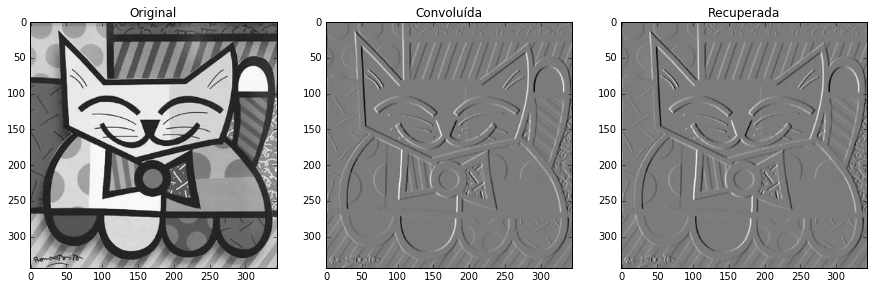

In [407]:
fig = np.array(figura)

a = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) #filtro passa alta

#aumento do filtro para deixar do mesmo tamanho da imagem
a2 = np.zeros(fig.shape)
r,c = a.shape
a2[:r,:c] = a

#convolve fig e a
fig_a = pconv(fig, a)

#fft da fig e a2
FIG = fft2(fig)
A2 = fft2(a2)

#Multiplicação das ffts
FIG_A2 = FIG * A2

#ifft FIG_A2
fig_a2 = ifft2(FIG_A2).real

print 'Verificação da teoria da convolução:', np.allclose(fig_a2, fig_a)

fig2, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(fig, cmap='gray')
ax[1].imshow(fig_a, cmap='gray')
ax[2].imshow(fig_a2, cmap='gray')

ax[0].set_title('Original')
ax[1].set_title(u'Convoluída')
ax[2].set_title(u'Recuperada')
plt.show()

#plt.imshow(FIG_H, cmap='gray')
#plt.show()

Analisando as imagens acima, podemos verificar a Teoria da Convolução. Dessa, maneira, os erros entre as imagens Convoluída e Recuperada são próximos de zero e imperceptível para a visão humana.

## Resolução Parte 3

In [408]:
def ponto(imagem, p):
    u, v = p
    m=np.zeros((imagem.shape))
    m[u, v] = 1
    m[-u, -v] = 1
    return m

In [409]:
# Obs.: Código inspirado no Jupyter do Mauro Brandão.
def reconstrucao_imagem(img, F2, n):
    lista = []
    aux = 1
    i = 0
    j = 0
    s = 1
    n_swap=n
    
    while n > 0:
        for ii in range(aux):
            i = i + s
            lista.append([i, j])
            n = n-1

        for jj in range(aux):
            j = j + s
            lista.append([i, j])
            n = n-1
        
        aux = aux + 1
        s = s * (-1)
        
    reconstrucao = np.zeros(img.shape)
    
    for i in range(n_swap):
        a = np.zeros(img.shape)
        u=lista[i][0]
        v=lista[i][1]
        a[u, v] = 1
        a[-u, -v] = 1
        P = ifft2(a*F2).real
        reconstrucao=reconstrucao+P
    return reconstrucao, P

In [410]:
fig = np.array(figura)
F2 = fft2(fig)

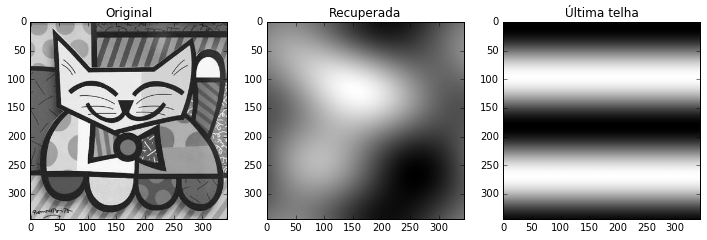

In [411]:
N = 10
y, P = reconstrucao_imagem(fig, F2, N)

fig4, ax = plt.subplots(1, 3, figsize=(12,12))
ax[0].imshow(normalize(fig), cmap='gray')
ax[1].imshow(normalize(y), cmap='gray')
ax[2].imshow(normalize(P), cmap='gray')

ax[0].set_title('Original')
ax[1].set_title(u'Recuperada')
ax[2].set_title(u'Última telha')
plt.show()

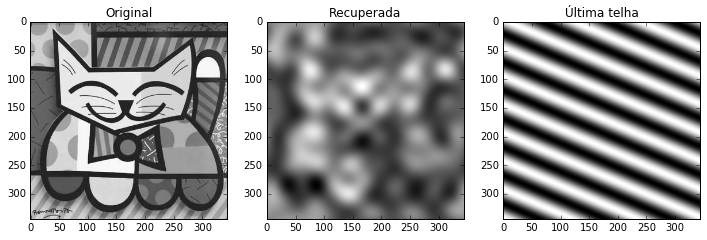

In [412]:
N = 200
y2, P2 = reconstrucao_imagem(fig, F2, N)

fig4, ax = plt.subplots(1, 3, figsize=(12,12))
ax[0].imshow(normalize(fig), cmap='gray')
ax[1].imshow(normalize(y2), cmap='gray')
ax[2].imshow(normalize(P2), cmap='gray')

ax[0].set_title('Original')
ax[1].set_title(u'Recuperada')
ax[2].set_title(u'Última telha')
plt.show()

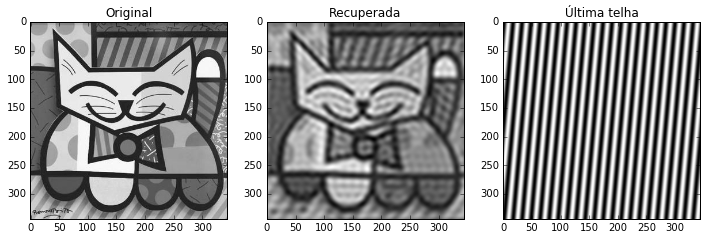

In [413]:
N = 2000
y3, P3 = reconstrucao_imagem(fig, F2, N)

fig4, ax = plt.subplots(1, 3, figsize=(12,12))
ax[0].imshow(normalize(fig), cmap='gray')
ax[1].imshow(normalize(y3), cmap='gray')
ax[2].imshow(normalize(P3), cmap='gray')

ax[0].set_title('Original')
ax[1].set_title(u'Recuperada')
ax[2].set_title(u'Última telha')
plt.show()

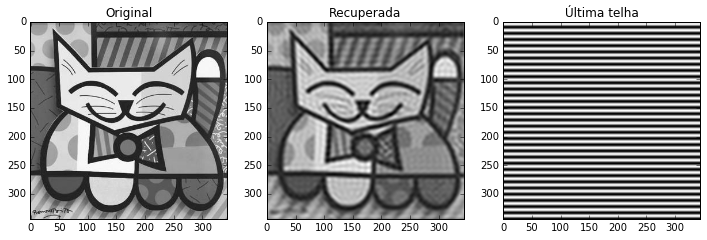

In [414]:
N = 4000
y4, P4 = reconstrucao_imagem(fig, F2, N)

fig4, ax = plt.subplots(1, 3, figsize=(12,12))
ax[0].imshow(normalize(fig), cmap='gray')
ax[1].imshow(normalize(y4), cmap='gray')
ax[2].imshow(normalize(P4), cmap='gray')

ax[0].set_title('Original')
ax[1].set_title(u'Recuperada')
ax[2].set_title(u'Última telha')
plt.show()

As imagens são construídas de acordo com a varredura ponto a ponto da Transformada de Fourier da imagem. Ou seja, cada ponto quando fazemos a transformada inversa de Fourier, é obtido o seno ou o cosseno da imagem junto com a sua frequência. Portanto, conforme aumenta a varredura, são obtidos mais senos e cossenos da imagem, possibilitando assim a recuperação da imagem de acordo com as iterações. Nesse trabalho foi parado com 4000 iterações, mas poderia aumentar para recuperar ainda mais a imagem.

#### Rascunho

In [400]:
lista = []
aux = 1
i = 0
j = 0
s = 1
n = 2000
n_swap=n

while n > 0:
    for ii in range(aux):
        i = i + s
        lista.append([i, j])
        n = n-1

    for jj in range(aux):
        j = j + s
        lista.append([i, j])
        n = n-1
        
    aux = aux + 1
    s = s * (-1)

reconstrucao=np.zeros(fig.shape)
for i in range(n_swap):
    a = np.zeros(fig.shape)
    u=lista[i][0]
    v=lista[i][1]
    a[u, v] = 1
    a[-u, -v] = 1
    P = ifft2(a*F2).real
    reconstrucao=reconstrucao+P

#plt.imshow(normalize(P), cmap='gray')
#plt.show()

#plt.imshow(normalize(reconstrucao), cmap='gray')
#plt.show()

#plt.imshow(normalize(fig), cmap='gray')
#plt.show()

#### Teste da Teoria da convolução com imagens numéricas

In [ ]:
h = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) #filtro simétrico

#aumentando o tamanho de h para a multiplicação
h2 = np.zeros(g.shape)
r,c = h.shape
h2[:r,:c] = h

#convolução das imagens
gh = pconv(g, h)

#fft da convolução
GH = fft2(gh)

#fft individual
G = fft2(g)
H2 = fft2(h2)

#multiplicação dos fft individuais
HG = G * H2

#fazendo a ifft de HG
hg = ifft2(HG).real

#erro = gh-hg
#print np.abs(np.around(erro))

#Verificação:
print 'Confirmação da teoria da convolução:', np.allclose(hg, gh)

#multiplicação g e h2
gh2 = g*h2

#convolve das ffts g e h independentes
GH2_conv = pconv(G, H2)

gh2_conv = ifft2(GH2_conv)

#Verificação:
print 'Confirmação da teoria da convolução:', np.allclose(gh2_conv.real, gh2)